In [10]:
!pip install kagglehub

In [11]:
from google.colab import files
files.upload()  # Upload your kaggle.json

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"bhumikaadhya05","key":"76f7c91a508c639053f3ec8ca5a655a0"}'}

In [12]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [13]:
import kagglehub

path = kagglehub.dataset_download("prithwirajmitra/covid-face-mask-detection-dataset")
print("Path to dataset files:", path)

100%|██████████| 207M/207M [00:02<00:00, 93.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/prithwirajmitra/covid-face-mask-detection-dataset/versions/1


In [15]:
import os

# List everything under the downloaded dataset folder
print("Top-level contents:")
print(os.listdir(path))

# Recursively walk and find folders
for root, dirs, files in os.walk(path):
    print("DIR:", root)
    print("SUBDIRS:", dirs)
    print("FILES:", files)
    print("-" * 40)

Top-level contents:
['New Masks Dataset']
DIR: /root/.cache/kagglehub/datasets/prithwirajmitra/covid-face-mask-detection-dataset/versions/1
SUBDIRS: ['New Masks Dataset']
FILES: []
----------------------------------------
DIR: /root/.cache/kagglehub/datasets/prithwirajmitra/covid-face-mask-detection-dataset/versions/1/New Masks Dataset
SUBDIRS: ['Validation', 'Train', 'Test']
FILES: []
----------------------------------------
DIR: /root/.cache/kagglehub/datasets/prithwirajmitra/covid-face-mask-detection-dataset/versions/1/New Masks Dataset/Validation
SUBDIRS: ['Mask', 'Non Mask']
FILES: []
----------------------------------------
DIR: /root/.cache/kagglehub/datasets/prithwirajmitra/covid-face-mask-detection-dataset/versions/1/New Masks Dataset/Validation/Mask
SUBDIRS: []
FILES: ['2543.png', '2530.png', '2316.png', '6415.png', '2025.jpg', '1818.jpg', '1896.jpg', '1779.jpeg', '1701.jpg', '2338.png', '2459.png', '2321.png', '1959.jpg', '2551.png', '1962.png', '1997.jpg', '2542.png', '2063

In [16]:
train_path = path + "/New Masks Dataset/Train"
val_path = path + "/New Masks Dataset/Validation"

# Confirm class folders
print("Train classes:", os.listdir(train_path))
print("Validation classes:", os.listdir(val_path))

Train classes: ['Mask', 'Non Mask']
Validation classes: ['Mask', 'Non Mask']


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image preprocessing
datagen = ImageDataGenerator(rescale=1./255)

# Load training images
train_data = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load validation images
val_data = datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 600 images belonging to 2 classes.
Found 306 images belonging to 2 classes.


In [18]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load base model without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze convolutional layers

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
history = model.fit(
    train_data,
    epochs=5,  # You can increase this later
    validation_data=val_data
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5251 - loss: 1.1450 - val_accuracy: 0.5261 - val_loss: 0.8028
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5504 - loss: 0.8570 - val_accuracy: 0.6438 - val_loss: 0.6410
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6656 - loss: 0.6551 - val_accuracy: 0.7157 - val_loss: 0.5414
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7098 - loss: 0.5872 - val_accuracy: 0.7908 - val_loss: 0.4659
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7622 - loss: 0.4779 - val_accuracy: 0.8529 - val_loss: 0.4016


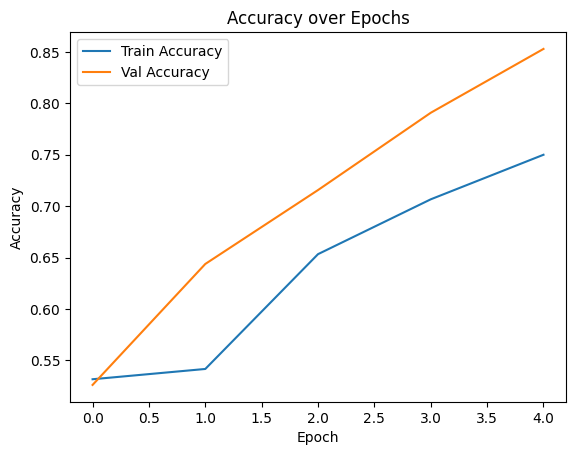

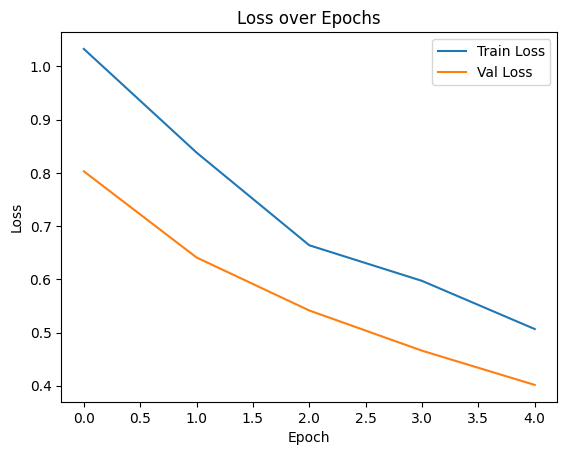

In [20]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# Save your trained model to file
model.save("face_mask_detector.h5")
print("Model saved as face_mask_detector.h5")

Model saved as face_mask_detector.h5


In [22]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load a test image (you can change the filename)
img_path = path + "/New Masks Dataset/Test/Mask/2113.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
class_names = list(train_data.class_indices.keys())
predicted_class = class_names[np.argmax(prediction)]

print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: Mask


In [28]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from PIL import Image
import io

# JS to capture webcam
def capture_webcam():
    display(Javascript('''
        async function capture() {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit Colab screen
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();

            return canvas.toDataURL('image/jpeg');
        }
        capture();
    '''))

# Run and capture
capture_webcam()
data = eval_js("capture()")
binary = b64decode(data.split(',')[1])
img = Image.open(io.BytesIO(binary)).convert('RGB')
img = img.resize((224, 224))
img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

# Predict
pred = model.predict(img_array)
predicted_class = class_names[np.argmax(pred)]
print("Prediction:", predicted_class)

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction: Non Mask


In [32]:
import requests
from PIL import Image
import io

# Example: Replace this with any mask/no-mask image URL
url = 'https://tse3.mm.bing.net/th?id=OIP.IaDPd1ZO0s8mjn7wcztqDAHaJ4&pid=Api&P=0&h=220'
response = requests.get(url)
img = Image.open(io.BytesIO(response.content)).convert('RGB')
img = img.resize((224, 224))

# Predict
img_array = np.expand_dims(np.array(img) / 255.0, axis=0)
pred = model.predict(img_array)
predicted_class = class_names[np.argmax(pred)]
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted class: Mask
